![](https://seeklogo.com/images/N/nba-75-years-logo-7E38B318A3-seeklogo.com.png)
# **Technical Report**
## CPSC322 Final Project
### Everett Johnson
### Luke Martin
### May 1, 2022
### NBA Team Success Predictor

#### **Project Overview**:
Professional basketball and sports gambling are billion-dollar industries. Our team attempts to solve a major problem that directly affects both fields. Every year, NBA general managers struggle with decisions involving which players to keep, trade, and go after in free agency. Their decisions determine a franchise’s long-term and short-term success, which can be measured in wins and/or revenue. Also every year, millions of dollars are wagered on the playoff and championship odds of every team. Both private gamblers and professional sportsbooks seek a way to more accurately predict the outcome of a team’s season given their roster. Knowing that a team like the superstar-less 2018-19 Los Angeles Clippers will make the playoffs or that the Hall of Fame-littered roster of the Lakers wouldn’t even be a .500 team is million-dollar information. 

Our project attempts to tackle this problem. We used classifiers to predict a team’s success. We created a class label for a team’s success by discretizing their win percentage. We then created multiple custom stats for teams based on the player stats for their top performers. These stats weight how many games the players played in one season so that injured or traded players don’t contribute more than they should to the team’s overall team success.

Then, in our deployment of our predictor, a user can enter a starting five for an NBA roster using player name and season combinations. Then our program combines the stats of the players to create an unseen instance. Our classifier then makes a prediction on the stats and returns a labeled prediction for the team’s success.


#### **Technical Report Overview**:
This document summarizes the work done and decisions made during the development of our team success predictor. Information about our data set, classifier selection, and implementation details are included below.

#### **Build Instructions**:
To build and deploy our predictor app, it must run locally. The app can easily be deployed to a web service platform such as Heroku. To run the app, run the python program `predictor_app.py` in the main directory of the repository. Since this is a Flask app, a URL will be displayed in the terminal the program ran in. Copy and paste that URL into a browser and the app will be loaded. Then players’ names can be entered for each of the five positions, as well as their corresponding seasons. A message will be displayed if one of the players is not in our dataset or if we don’t have a season for one of the particular players. Otherwise, a message will display giving a labeled prediction for that team’s success. 

#### **Data Source**:

The data for our project was gathered from [basketball-reference](https://www.basketball-reference.com/). The statistics used in this project were already available in a nice, clean format that was ready to use. We use two main sources of data: player stats and team records. We used our own implemented `MyPyTable` to load the data and make it usable for our purpose. This involved combining thirty years' worth of player and team data, and then using methods such as groupby to combine the data. The player stats that we ended up using are included below. Other stats were looked at, but often lowered our predictive accuracy for all classifiers, so we ended with these.

##### **Player Stats**:
* Name
* Season (Used for groupby)
* Team (Used for groupby)
* MPG - Minutes Per Game
* PPG - Points Per Game
* APG - Assists Per Game
* RPB - Rebounds Per Game
* FG/FT/3PT% - Field Goal/Free Throw/Three-Point Percentage

##### **Team Records**:
* Team
* Record
* Home
* Away

#### **Custom Stat Implementation**:

One of the more challenging parts of our project was be creating a dataset that contains all the information we want that a model can learn from. We wanted to numerically describe a team based upon the statistics of each of its players. Since we are trying to use this information in a classification task, we need each team/year pair to have exactly one instance associated with it. Namely, we need to combine the statistics of all players on a roster into a set number of attribute values. This is difficult as many rosters have different numbers of players and minutes vary for all of the players on those rosters. For example, we don’t want a 40-year old Udonis Haslem’s stats to negatively affect the prediction for the Miami Heat’s success when he is consistently not playing in any games. On the other end, Nikola Jokic’s stats should positively affect the Nugget’s success prediction as he is playing close to 40 minutes a game. The idea is to take every player stat and combine them into one weighted stat per team. A classic stat used to mitigate this issue would be a player's per 36 minutes stat. This takes a player's stat (ppg, rpg, etc.) and adjusts it corresponding to how many minutes the players gets per game. 

As an example a player's points per 36 minutes is calculated by:
$$ ppg_{per 36} = \frac{36*ppg}{mpg} $$
where $ppg$ is a player's points per game stat and $mpg$ is minutes per game.

This stat normalizes player data to attempt to predict how a player would perform in an increased rule. The problem is that players who are playing very few minutes have their point infinitely increased, which is not realistic at all for players who already don't have a huge rule.

For our project, we created a custom stat that gives more accurate adjustment to players. The requirement for our function is that at 36 minutes, the players points per game would not change, since we wanted it to behave similarly to the per 36 stat, but without giving such wild adjustments to bench players. The stat we finalized for points per game we called the *jortin* point stat, which was named after its two creators. The formula is given below. 

$$ ppg_{jortin} = -\sqrt{9 * mpg} + ppg + 18 $$

Shown below is a graph of the *jortin* compared to the per 36 stat to emphasis the neccessity of the *jortin* stat for a 20 points per game scorer.

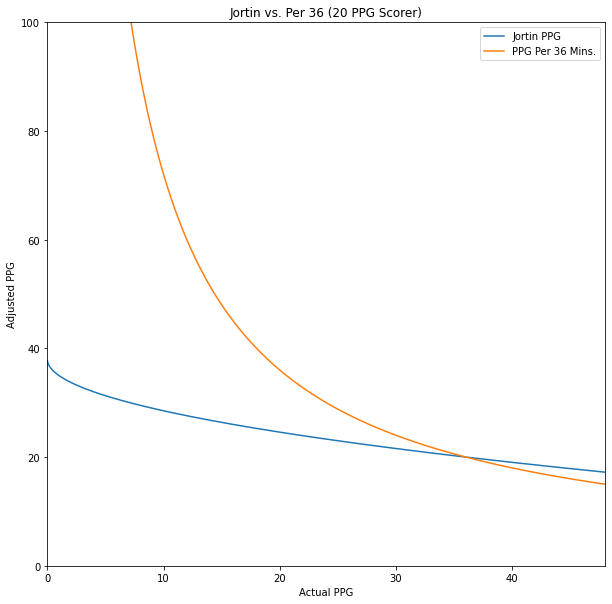

In [1]:
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np

def jortin_per_36(points_per_game, minutes_per_game):
    """This function calculates the weighted points per game based on
    the minutes played per game according to jortin score.
    """
    return -1 * sqrt(9 * minutes_per_game) + points_per_game + 18

def per_36(points_per_game, minutes_per_game):
    """This function calculates the weighted points per game based on
    the minutes played per game according to original per 36.
    """
    return (36 * points_per_game) / minutes_per_game

ppg_ex = 20
x_range = np.arange(0.01, 48, 0.01)
jortin_scores = [jortin_per_36(ppg_ex, x) for x in x_range]
per_36_scores = [per_36(ppg_ex, x) for x in x_range]

plt.figure(figsize=(10,10))
plt.plot(x_range, jortin_scores, label="Jortin PPG")
plt.plot(x_range, per_36_scores, label="PPG Per 36 Mins.")
plt.title("Jortin vs. Per 36 (20 PPG Scorer)")
plt.legend()
plt.xlabel("Actual PPG")
plt.ylabel("Adjusted PPG")
plt.ylim([0, 100])
plt.xlim([0, 48])
plt.show()

It is easy to see that the number of points a player has for their adjusted score is unbounded as their minutes head towards 0. This is true for all points per game. However, the *jortin* score is always bounded.


#### **Exploratory Data Analysis**:

We had to use data exploration to make a lot of decisions for how we were going to combine player stats as well as discretizing team stats. One of the main decisions to make was how to discretize the win percentage, which would ultimately be our class label we want to predict. It was important to get a sense for the distribution of win percentages in our dataset. For that, a histogram works nicely. 

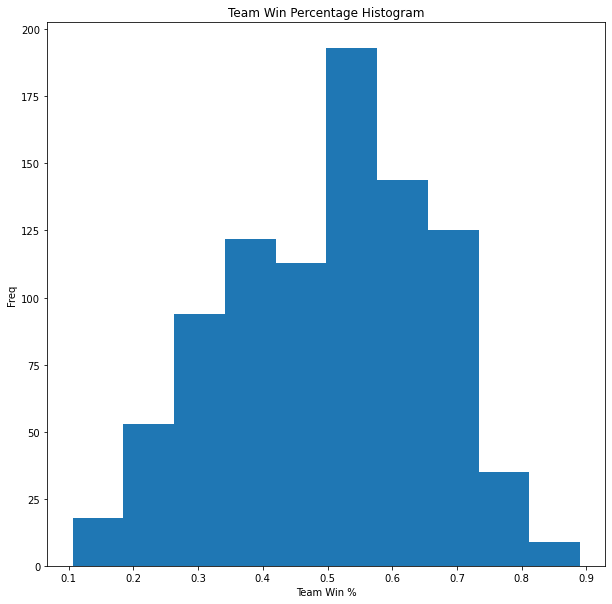

In [2]:
import os
from mysklearn.mypytable import MyPyTable

file_loc = os.path.join("input_data", "processed_data", "team_info.csv")
team_data = MyPyTable().load_from_file(file_loc)
win_percentage = team_data.get_column("Win Percentage")

plt.figure(figsize=(10, 10))
plt.xlabel("Team Win %")
plt.ylabel("Freq")
plt.title("Team Win Percentage Histogram")
plt.hist(win_percentage, bins=10)
plt.show()

Using this distribution, we decided on our discretizer as shown below. It made for a fairly even distribution, with fewer teams in the lowest and highest bins.

In [3]:
def discretize_win_percent(percent): # games won if 82 game season
    """This function takes in raw win percentage and returns the discretized value
    """
    if percent < 0.25: # <20 games won
        return 1
    elif percent < 0.40: # <33 games won
        return 2
    elif percent < 0.55: # <46 games won
        return 3
    elif percent < 0.70: # <58 games won
        return 4
    else: # >58 games won
        return 5

It was also really important to discretize the weighted jppg stat in order to test the data against classifiers that needed discrete values (such as `MyDecisionTreeClassifier`)

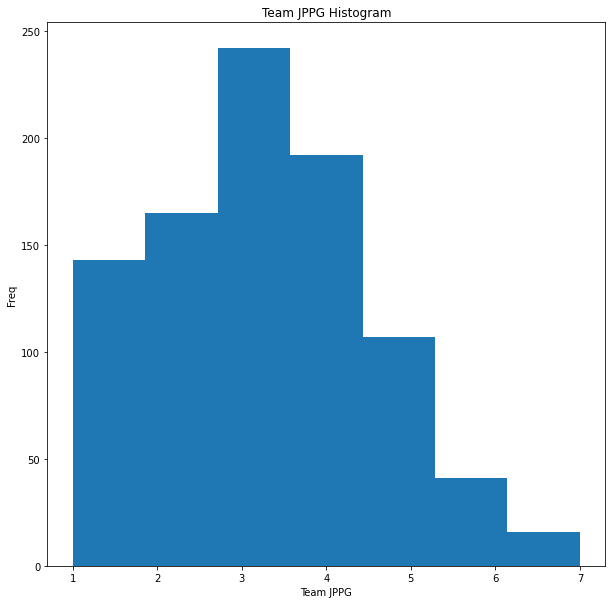

In [4]:
file_loc = os.path.join("input_data", "processed_data", "team_stats.csv")
team_stats = MyPyTable().load_from_file(file_loc)
jppg = team_stats.get_column("JPPG")

plt.figure(figsize=(10, 10))
plt.xlabel("Team JPPG")
plt.ylabel("Freq")
plt.title("Team JPPG Histogram")
plt.hist(jppg, bins=7)
plt.show()

The histogram shows that our JPPG discretizer worked in the way we wanted it to, since it has a normal-like shape, with the right most bin having very few teams. This will ensure that only elite offensive teams get the highest class label.

#### **Classifier Selection**:

Through multiple iterations of changing classification parameters and feature subsets, we found the k-nearest neighbors classifier with $k=10$ to be our optimal classifier. It was deployed on our flask app using the `pickle` library. But shown below are results for knn as well as other classifiers.

In [5]:
from tabulate import tabulate
import mysklearn.myevaluation as myeval
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyNaiveBayesClassifier, MyDummyClassifier
from mysklearn.myensembleclassifiers import MyRandomForestClassifier

file_loc = os.path.join("input_data", "processed_data", "team_stats.csv")
team_stats = MyPyTable().load_from_file(file_loc)

y = team_stats.get_column("Success")
team_stats.drop_column("Success")
team_stats.drop_column("Team")
team_stats.drop_column("Season")
X = team_stats.data

dummy = MyDummyClassifier()
print("Dummy Acc:", myeval.kfold_accuracy(X, y, dummy, n_splits=3,random_state=0))

knn = MyKNeighborsClassifier(10)
print("KNN Acc:", myeval.kfold_accuracy(X, y, knn, n_splits=3, random_state=0))
print(tabulate(myeval.kfold_confusion_matrix(X, y, [1, 2, 3, 4, 5], knn, n_splits=3, random_state=0)))

nb = MyNaiveBayesClassifier()
print("Naive Bayes Acc:", myeval.kfold_accuracy(X, y, nb, n_splits=3, random_state=0))
print(tabulate(myeval.kfold_confusion_matrix(X, y, [1, 2, 3, 4, 5], nb, n_splits=3, random_state=0)))

trees = MyRandomForestClassifier()
print("Random Forest Acc:", myeval.kfold_accuracy(X, y, trees, n_splits=3, random_state=0))
print(tabulate(myeval.kfold_confusion_matrix(X, y, [1, 2, 3, 4, 5], trees, n_splits=3, random_state=0)))

Dummy Acc: 0.33774834437086093
KNN Acc: 0.41832229580573954
-  -  --  ---  ---  --  -----  ---------------
   1   2    3    4   5  Total  Recognition (%)
1  8  20   27    2   0  57     14
2  3  53  113   17   1  187    28
3  4  41  196   63   2  306    64
4  0  10  137  117  10  274    43
5  0   2   26   49   5  82     6
-  -  --  ---  ---  --  -----  ---------------
Naive Bayes Acc: 0.42935982339955847
-  --  --  ---  ---  --  -----  ---------------
    1   2    3    4   5  Total  Recognition (%)
1  23  16   13    5   0  57     40
2  25  63   75   22   2  187    34
3  16  55  149   80   6  306    49
4   1  13   94  137  29  274    50
5   0   3   13   49  17  82     21
-  --  --  ---  ---  --  -----  ---------------
Random Forest Acc: 0.41832229580573954
-  -  --  ---  ---  -  -----  ---------------
   1   2    3    4  5  Total  Recognition (%)
1  1  29   26    1  0  57     2
2  1  56   87   42  1  187    30
3  1  69  150   81  5  306    49
4  0  19  119  129  7  274    47
5  0   5   2

Even though the classifiers only had an accuracy of about 10% higher than the dummy, the confusion matrices do a good job of reflecting the increased power of the classifiers. Most of the predictions are in a range of +/- 1 class label, so they are actually doing much better than our baseline.

All of the classifiers had similar accuracy results, but what determined our final decision was how the predictions looked in comparison to the main diagonal. We liked how close the results were to the diagonal in the knn, and felt very confident in its implementation, so we used that classifier for the final deployment. 

#### **Results**:
See the pdf of the presentation slides for examples of our interface running with predictions.

#### **Project Application**:

The main two serious applications of this model would be roster construction for NBA front offices and for decision-making for sports bettors. If a successful enough model is created, the predictions for next season’s teams can be used to place bets on teams making and missing playoffs. Sports gambling is a multi-billion dollar industry, so any classifier that could make accurate sports predictions would be invaluable in this field. It would also satisfy fans' creative imaginations allowing them to combine players from different eras onto rosters to see how the team would play out. For example, Michael Jordan and LeBron could be on a team and its success could be predicted.

Although this predictor is not accurate enough to be seriously considered for use in an NBA office, it does gives a baseline for how a more accurate success predictor could be created. 


#### **Sources**:

Data: [basketball-reference](https://www.basketball-reference.com/)

General Classification Help: [CPSC322 Course Github](https://github.com/GonzagaCPSC322)

HTML Template Page: [Dr. Sprint's HTML Interview Template](https://github.com/GonzagaCPSC322/U6-APIs-Model-Deployment/tree/master/APIServiceFunWithGUIForm/templates)

Player Accent Decoding: [Unidecode documentation](https://pypi.org/project/Unidecode/)